# Demographics Cluster for Customer

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go

## 1. Data preparation & Feature engineering

In [25]:
customer = pd.read_csv('twm_customer.csv', sep=';')
df = pd.DataFrame(customer)
df.dtypes

cust_id             int64
income              int64
age                 int64
years_with_bank     int64
nbr_children        int64
gender             object
marital_status      int64
name_prefix        object
first_name         object
last_name          object
street_nbr          int64
street_name        object
postal_code         int64
city_name          object
state_code         object
dtype: object

In [26]:
df.head()

,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,first_name,last_name,street_nbr,street_name,postal_code,city_name,state_code
0,1362691,26150,46,5,1,M,2,,Donald ...,Marek ...,8298,Second ...,89194,Las Vegas,NV
1,1362487,6605,71,1,0,M,2,,ChingDyi ...,Moussavi ...,10603,Daffodil ...,90159,Los Angeles,CA
2,1363160,18548,38,8,0,F,1,,Rosa ...,Johnston ...,8817,Figueroa ...,90024,Los Angeles,CA
3,1362752,47668,54,3,0,F,1,,Lisa ...,Martin ...,676,Humble ...,90172,Los Angeles,CA
4,1362548,44554,59,9,2,F,4,,Barbara ...,O'Malley ...,6578,C ...,10138,New York City,NY


In [27]:
df.drop(columns=[
    'first_name', 'last_name', 'street_name', 'city_name',
    'cust_id', 'name_prefix', 'street_nbr',
    'state_code', 'years_with_bank', 'postal_code'
], inplace=True)

In [28]:
 df_gender = pd.get_dummies(df['gender'])
df_new = pd.concat([df, df_gender], axis=1)
marital_status = pd.get_dummies(df['marital_status'])

df_new = pd.concat([df_new, marital_status], axis=1)
df_new = df_new.drop(columns=['gender','marital_status'])
df_new.columns=['income', 'age', 'nbr_children', 'F', 'M','marital_status_1', 'marital_status_2', 'marital_status_3', 'marital_status_4']

df_new


,income,age,nbr_children,F,M,marital_status_1,marital_status_2,marital_status_3,marital_status_4
0,26150,46,1,0,1,0,1,0,0
1,6605,71,0,0,1,0,1,0,0
2,18548,38,0,1,0,1,0,0,0
3,47668,54,0,1,0,1,0,0,0
4,44554,59,2,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
742,14795,36,1,1,0,0,0,0,1
743,26387,56,1,0,1,0,1,0,0
744,61300,50,2,0,1,0,1,0,0
745,15100,37,0,1,0,0,1,0,0


## 2.Dimensionality Reduction

#### - PCA reduce to 2D for Kmeans plot

In [29]:
df_new.shape

(747, 9)

In [81]:
x = df_new
# PCA use standardscaler as normalization is important in PCA since it is a variance maximizing exercise

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_std = sc.fit_transform(x)

In [82]:
# PCA to reduce dimension to 2D
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_std)
x_pca.shape

(747, 2)

In [83]:
#PCA 2D plot
# """axis-label name"""
x_lbl, y_lbl = 'PCA 1', 'PCA 2'

# """data at eact axis to plot"""
x_plot, y_plot = x_pca[:,0], x_pca[:,1]


fig = go.Figure(data=[go.Scatter(x=x_plot, y=y_plot, mode='markers', 
                marker=dict(size=8,opacity=0.5))])
fig.update_layout(xaxis_title=x_lbl, yaxis_title=y_lbl,
    yaxis = dict(scaleanchor = "x",scaleratio = 1) )
fig.show()

## 3. Unsupervised Learning
#### - Kmeans to find cluster (use PCA-2D for graph)

In [84]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df_new)

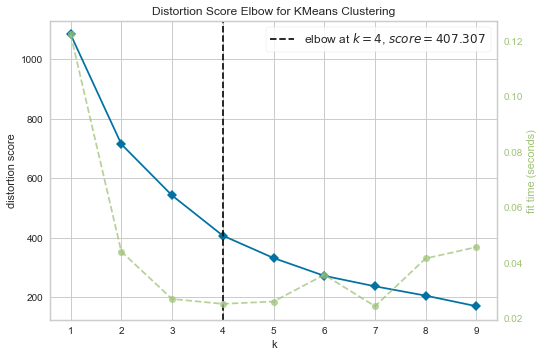

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [85]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(scaled_df)    
visualizer.poof()

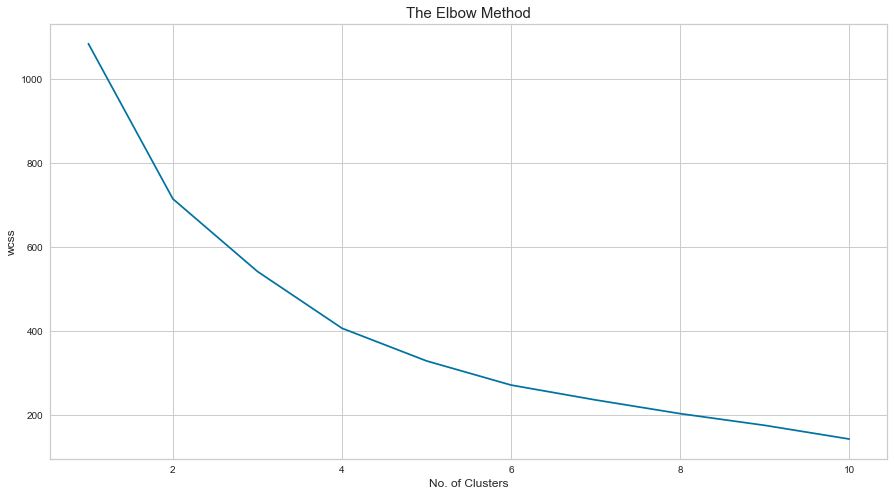

In [86]:
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(scaled_df)
    wcss.append(km.inertia_)

plt.figure(figsize=(15,8))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 15)
plt.xlabel('No. of Clusters', fontsize = 12)
plt.ylabel('wcss', fontsize = 12)
plt.show()  

In [87]:
# 5 clusters from elbow plot 
km = KMeans(n_clusters=4)
y_km = km.fit_predict(scaled_df)

In [88]:
def plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        x = X[y_res == cluster, 0]
        y = X[y_res == cluster, 1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        plt.scatter(x,
                    y,
                    s=50,
                    marker='s',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='black',
                    s=250,
                    label='centroids')
    plt.legend()
    plt.show()

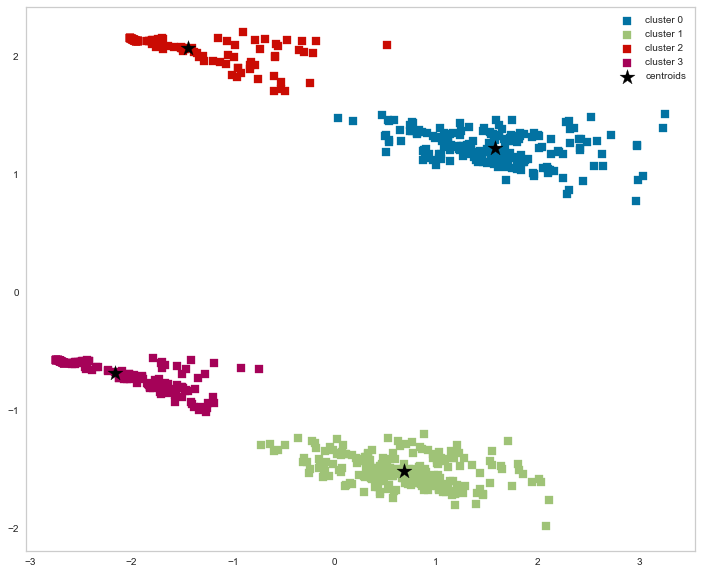

In [77]:
# customer demographics
from matplotlib.pyplot import figure
figure(figsize=(12, 10))
plt.grid(None)
plot_clusters(x_pca, y_km, plt_cluster_centers= True)


## 4. Radar charts (plotly)

In [78]:
df_new['cluster'] = KMeans(n_clusters=4, n_init=10).fit_predict(df_new)
df_new['cluster'].value_counts()
df_radar = df_new.groupby('cluster').mean().divide(df_new.drop('cluster',axis=1).mean())
df_radar.head()


,income,age,nbr_children,F,M,marital_status_1,marital_status_2,marital_status_3,marital_status_4
cluster,,,,,,,,,
0,0.254202,0.889464,0.403280,1.078689,0.900025,1.422346,0.768930,0.560811,0.801158
1,2.052175,1.092223,1.931782,0.893541,1.135258,0.537008,1.259611,1.482143,1.185714
2,3.912601,1.173864,1.172032,0.482995,1.656864,0.512045,0.972284,3.364865,1.442085
3,1.031914,1.074722,1.298559,1.025258,0.967910,0.744024,1.180321,0.992032,1.105407


In [80]:
import plotly.graph_objects as go

# categories = ['Income', 'Age', 'Number of children', 'Gender', 'Female', 'Male', 'Marital Status 1','Marital Status 2', 'Marital Status 3', 'Marital Status 4',    ]

fig = go.Figure()

for i in df_radar.index:
  fig.add_trace(
                go.Scatterpolar(
                                r=df_radar.loc[i].values,
                                theta=df_radar.columns,
                                fill='toself',
                                name=f'Cluster {i} ',
                                )
                )


fig.update_layout(
    polar=dict(
        radialaxis=dict(
          visible=True,
        ),
      ),
    showlegend=True,
    title="Customer Demographics Radar"
)

fig.show()

In [89]:
# Cluster 0 : customers who have lowest income, youngest, lowest number of children, gender not distinct, Marital status 1
# Cluster 1 : customers who have 2nd high income, 2nd oldest, mostly Male, Marital status 3, highest nbr of children
# Cluster 2 : customers who have highest income, oldest, mostly Male, Marital status 3, low nbr of children 
# Cluster 3 : customers who have 3rd high income, small nbc of children, 3rd oldest, gender & Marital status not distinct, 

# Marital status: 1 = Married, 2 = widowed, 3 = Separated, 4 = Divorced

## 5. Kmeans Iterations(unfinished)

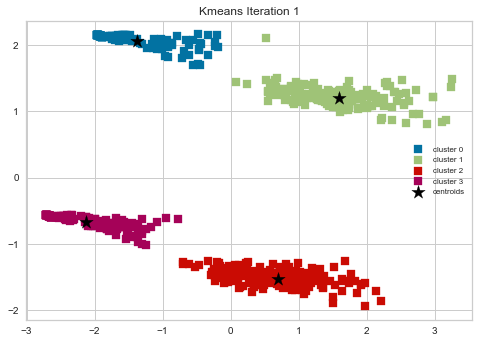

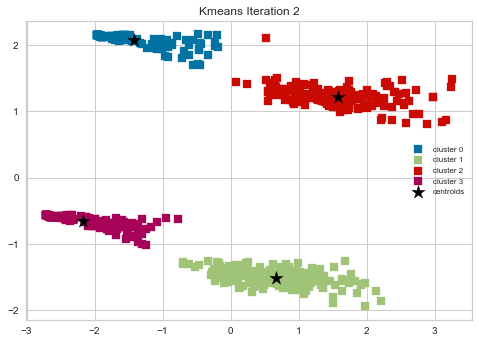

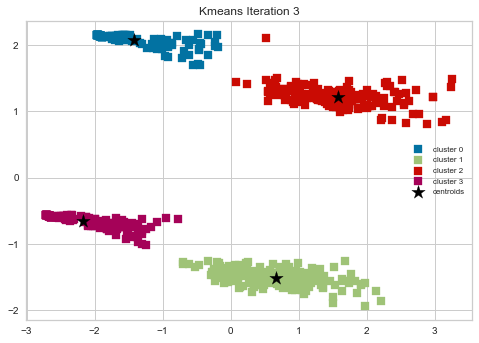

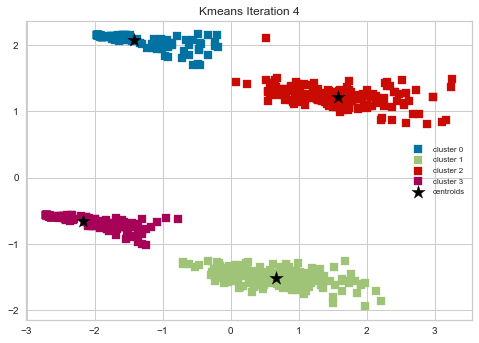

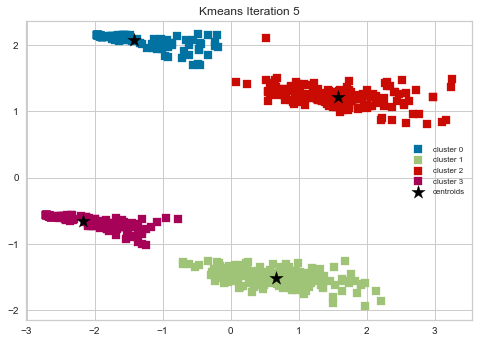

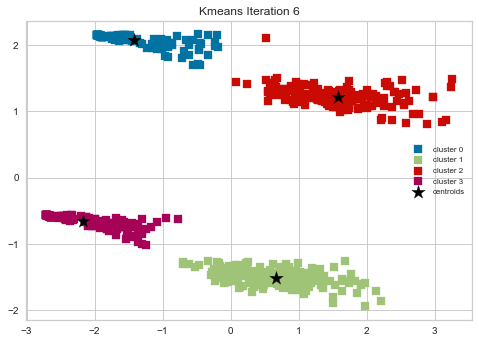

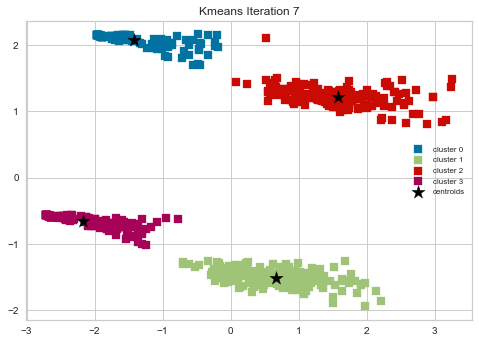

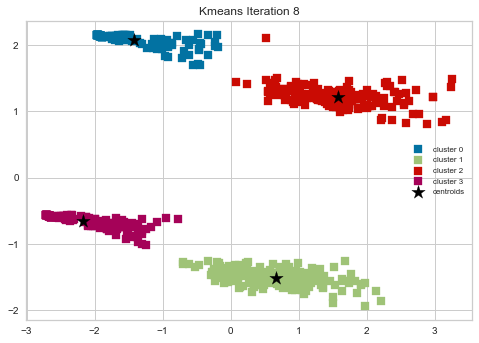

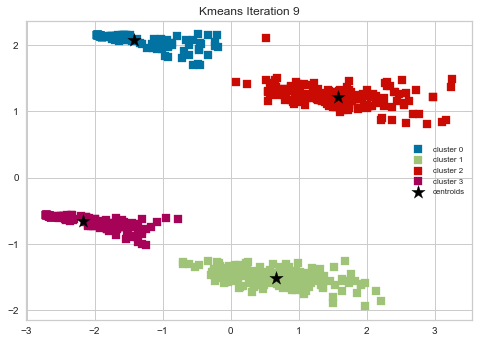

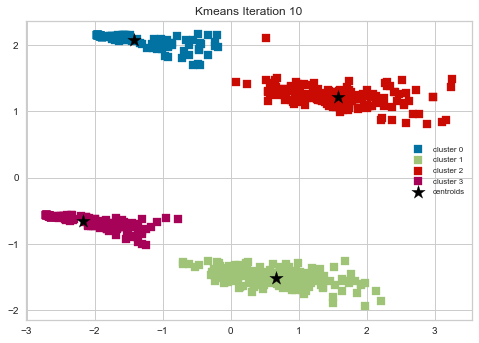

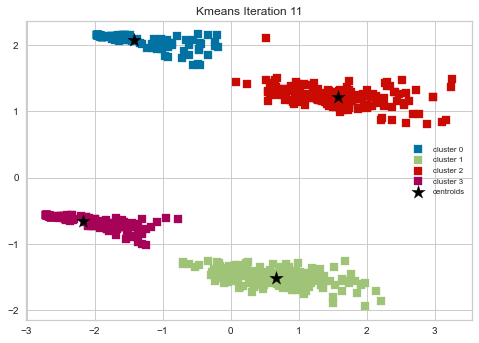

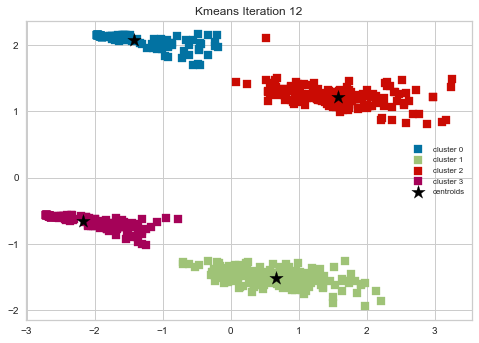

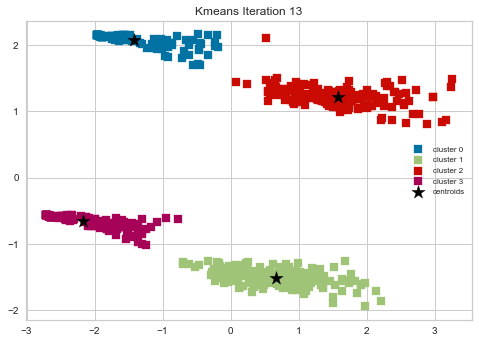

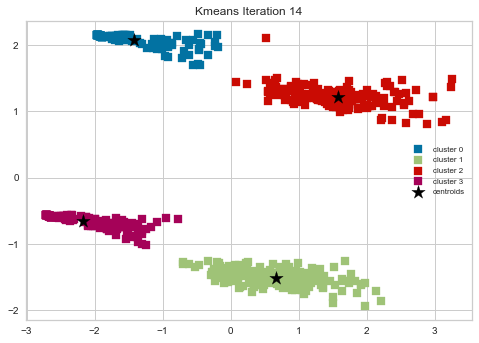

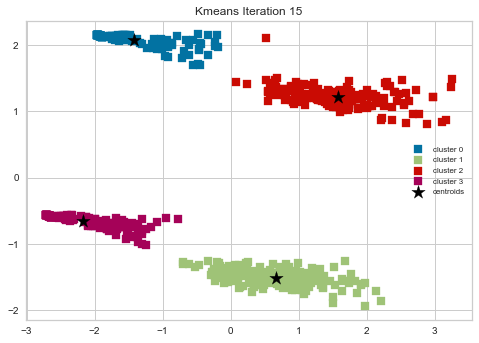

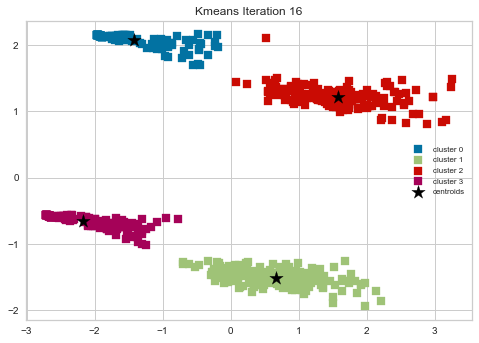

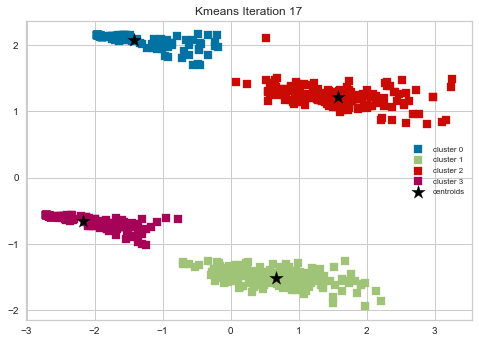

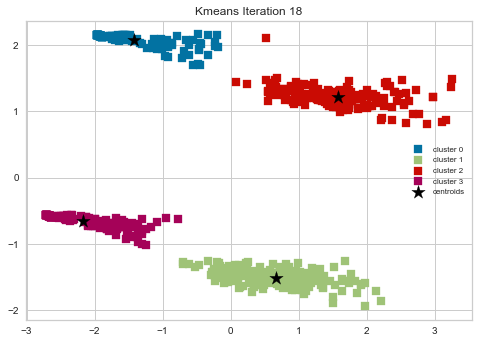

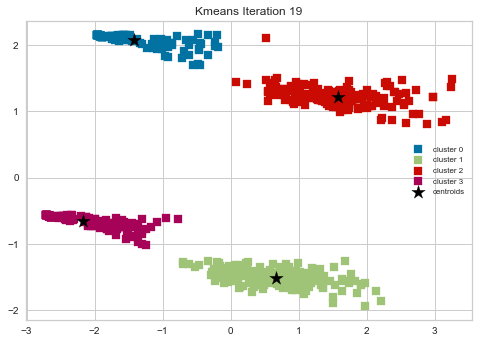

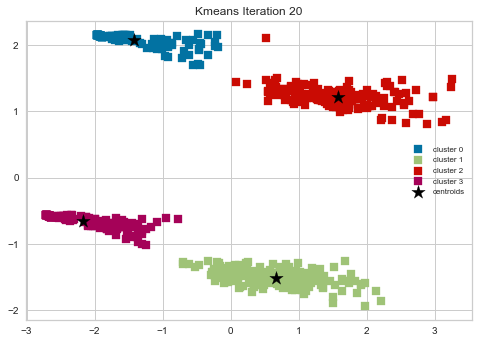

In [41]:
for i in range(1,21):
    if i == 1:
        km = KMeans(n_clusters=4, init='random', max_iter=1, random_state=0).fit(x_pca)
    else:
        km = KMeans(n_clusters=4, max_iter=i, random_state=0).fit(x_pca)
    label = km.labels_
    centroid = km.cluster_centers_
    for cluster in set(label):
        x = x_pca[label == cluster, 0]
        y = x_pca[label == cluster, 1]
        plt.scatter(x, y,
                    s=50,
                    marker='s',
                    label=f'cluster {cluster}')
    plt.scatter(centroid[:, 0], centroid[:, 1],
                marker='*',
                c='black',
                s=200,
                label='centroids')
    plt.legend(loc = 'right', prop={'size':8})
    plt.title(f'Kmeans Iteration {i}')
    plt.show()